In [1]:
# Setup and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Custom modules
import sys
sys.path.insert(0, '../05_Scripts/')
from model_utils import set_random_seeds, save_model
from evaluation import calculate_all_metrics, generate_evaluation_report

# Settings
set_random_seeds(42)
pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')

print("✅ Setup complete!")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"XGBoost: {xgb.__version__}")

INFO:model_utils:Random seeds set to 42


✅ Setup complete!
NumPy: 2.3.4
Pandas: 2.3.3
XGBoost: 3.1.2


## 1. Load and Prepare Data

In [2]:
# Paths
DATA_PATH = Path('../02_Data/Processed/')
MODEL_PATH = Path('../02_Model_Development/Trained_Models/')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Load data
df = pd.read_csv(DATA_PATH / 'features_engineered.csv')
print(f"Dataset shape: {df.shape}")

# Target and features
target_col = 'congestion_index'
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in numeric_cols if col != target_col]

# Clean data
df[feature_cols] = df[feature_cols].fillna(0)

# Feature correlation analysis
correlations = df[feature_cols + [target_col]].corr()[target_col].drop(target_col).abs().sort_values(ascending=False)
print(f"\n📊 Top 10 Features by Correlation with Target:")
print(correlations.head(10))

# Select top features (correlation > 0.1)
selected_features = correlations[correlations > 0.1].index.tolist()
print(f"\n✅ Selected {len(selected_features)} features with correlation > 0.1")

Dataset shape: (1652, 37)

📊 Top 10 Features by Correlation with Target:
congestion_index_rolling_mean_7     0.841521
congestion_index_rolling_mean_14    0.823684
congestion_index_rolling_max_7      0.800710
congestion_index_rolling_min_7      0.795872
congestion_index_rolling_mean_30    0.795147
congestion_index_rolling_min_14     0.781588
congestion_index_rolling_max_14     0.778964
month_sin                           0.776353
congestion_index_rolling_min_30     0.758383
congestion_index_rolling_max_30     0.743791
Name: congestion_index, dtype: float64

✅ Selected 21 features with correlation > 0.1


## 2. Create Train/Val/Test Split

In [3]:
# Temporal split: 60% train, 20% val, 20% test
n = len(df)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

# Use selected features
X_train = train_df[selected_features].values
y_train = train_df[target_col].values

X_val = val_df[selected_features].values
y_val = val_df[target_col].values

X_test = test_df[selected_features].values
y_test = test_df[target_col].values

# Combine train and val for final training
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

print(f"Training: {X_train.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test: {X_test.shape}")
print(f"Full Training (train+val): {X_train_full.shape}")

Training: (991, 21)
Validation: (330, 21)
Test: (331, 21)
Full Training (train+val): (1321, 21)


## 3. Hyperparameter Tuning with Time Series CV

In [4]:
# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

# XGBoost hyperparameter space
xgb_param_dist = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [4, 6, 8, 10, 12],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.5, 1, 2, 5]
}

print("Starting XGBoost hyperparameter tuning...")
print(f"Search space size: ~{np.prod([len(v) for v in xgb_param_dist.values()])} combinations")

xgb_base = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

xgb_search = RandomizedSearchCV(
    xgb_base,
    xgb_param_dist,
    n_iter=50,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

xgb_search.fit(X_train_full, y_train_full)

print(f"\n✅ XGBoost Best CV RMSE: {-xgb_search.best_score_:.4f}")
print(f"Best parameters: {xgb_search.best_params_}")

Starting XGBoost hyperparameter tuning...
Search space size: ~138240 combinations
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✅ XGBoost Best CV RMSE: 4.6933
Best parameters: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 300, 'min_child_weight': 7, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.7}


In [5]:
# Random Forest hyperparameter tuning
rf_param_dist = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [10, 15, 20, 25, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.3, 0.5],
    'bootstrap': [True, False]
}

print("Starting Random Forest hyperparameter tuning...")

rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_search = RandomizedSearchCV(
    rf_base,
    rf_param_dist,
    n_iter=50,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rf_search.fit(X_train_full, y_train_full)

print(f"\n✅ Random Forest Best CV RMSE: {-rf_search.best_score_:.4f}")
print(f"Best parameters: {rf_search.best_params_}")

Starting Random Forest hyperparameter tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✅ Random Forest Best CV RMSE: 4.6757
Best parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': None, 'bootstrap': True}


In [6]:
# Gradient Boosting hyperparameter tuning
gb_param_dist = {
    'n_estimators': [200, 300, 400],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5]
}

print("Starting Gradient Boosting hyperparameter tuning...")

gb_base = GradientBoostingRegressor(random_state=42)

gb_search = RandomizedSearchCV(
    gb_base,
    gb_param_dist,
    n_iter=50,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

gb_search.fit(X_train_full, y_train_full)

print(f"\n✅ Gradient Boosting Best CV RMSE: {-gb_search.best_score_:.4f}")
print(f"Best parameters: {gb_search.best_params_}")

Starting Gradient Boosting hyperparameter tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✅ Gradient Boosting Best CV RMSE: 4.7047
Best parameters: {'subsample': 0.7, 'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.01}


## 4. Create Optimized Ensemble

In [7]:
from scipy.optimize import minimize

# Get best models
xgb_best = xgb_search.best_estimator_
rf_best = rf_search.best_estimator_
gb_best = gb_search.best_estimator_

# Get predictions on validation set for weight optimization
# Retrain on train only, evaluate on val
xgb_best.fit(X_train, y_train)
rf_best.fit(X_train, y_train)
gb_best.fit(X_train, y_train)

val_preds = np.column_stack([
    xgb_best.predict(X_val),
    rf_best.predict(X_val),
    gb_best.predict(X_val)
])

# Optimize ensemble weights
def ensemble_rmse(weights):
    weights = np.array(weights) / np.sum(weights)  # Normalize
    pred = val_preds @ weights
    return np.sqrt(mean_squared_error(y_val, pred))

# Initial: equal weights
initial_weights = [1/3, 1/3, 1/3]

# Optimize
result = minimize(
    ensemble_rmse,
    initial_weights,
    method='SLSQP',
    bounds=[(0, 1), (0, 1), (0, 1)],
    constraints={'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
)

optimal_weights = result.x / result.x.sum()
print(f"\n🏆 Optimal Ensemble Weights:")
print(f"   XGBoost:          {optimal_weights[0]:.3f}")
print(f"   Random Forest:    {optimal_weights[1]:.3f}")
print(f"   Gradient Boosting: {optimal_weights[2]:.3f}")
print(f"\nOptimized Ensemble Val RMSE: {result.fun:.4f}")


🏆 Optimal Ensemble Weights:
   XGBoost:          0.609
   Random Forest:    0.391
   Gradient Boosting: 0.000

Optimized Ensemble Val RMSE: 4.7296


## 5. Final Training and Evaluation

In [8]:
# Retrain on full training data (train + val)
print("Retraining models on full training data...")

xgb_final = xgb.XGBRegressor(**xgb_search.best_params_, random_state=42, n_jobs=-1)
rf_final = RandomForestRegressor(**rf_search.best_params_, random_state=42, n_jobs=-1)
gb_final = GradientBoostingRegressor(**gb_search.best_params_, random_state=42)

xgb_final.fit(X_train_full, y_train_full)
rf_final.fit(X_train_full, y_train_full)
gb_final.fit(X_train_full, y_train_full)

# Get test predictions
test_preds = {
    'XGBoost': xgb_final.predict(X_test),
    'Random Forest': rf_final.predict(X_test),
    'Gradient Boosting': gb_final.predict(X_test),
}

# Ensemble prediction
test_pred_matrix = np.column_stack(list(test_preds.values()))
test_preds['Ensemble'] = test_pred_matrix @ optimal_weights

# Evaluate all
print("\n" + "="*70)
print("FINAL TEST SET EVALUATION")
print("="*70)

results = {}
for name, y_pred in test_preds.items():
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    
    mae_ok = '✅' if mae < 5.0 else '⚠️'
    rmse_ok = '✅' if rmse < 8.0 else '⚠️'
    r2_ok = '✅' if r2 > 0.75 else '⚠️'
    
    print(f"\n{name}:")
    print(f"   MAE:  {mae:.4f} {mae_ok}")
    print(f"   RMSE: {rmse:.4f} {rmse_ok}")
    print(f"   R²:   {r2:.4f} {r2_ok}")

print("\n" + "="*70)

Retraining models on full training data...

FINAL TEST SET EVALUATION

XGBoost:
   MAE:  3.8538 ✅
   RMSE: 4.7520 ✅
   R²:   0.6736 ⚠️

Random Forest:
   MAE:  3.8286 ✅
   RMSE: 4.7542 ✅
   R²:   0.6733 ⚠️

Gradient Boosting:
   MAE:  3.8899 ✅
   RMSE: 4.7833 ✅
   R²:   0.6693 ⚠️

Ensemble:
   MAE:  3.8338 ✅
   RMSE: 4.7413 ✅
   R²:   0.6751 ⚠️



## 6. Visualization

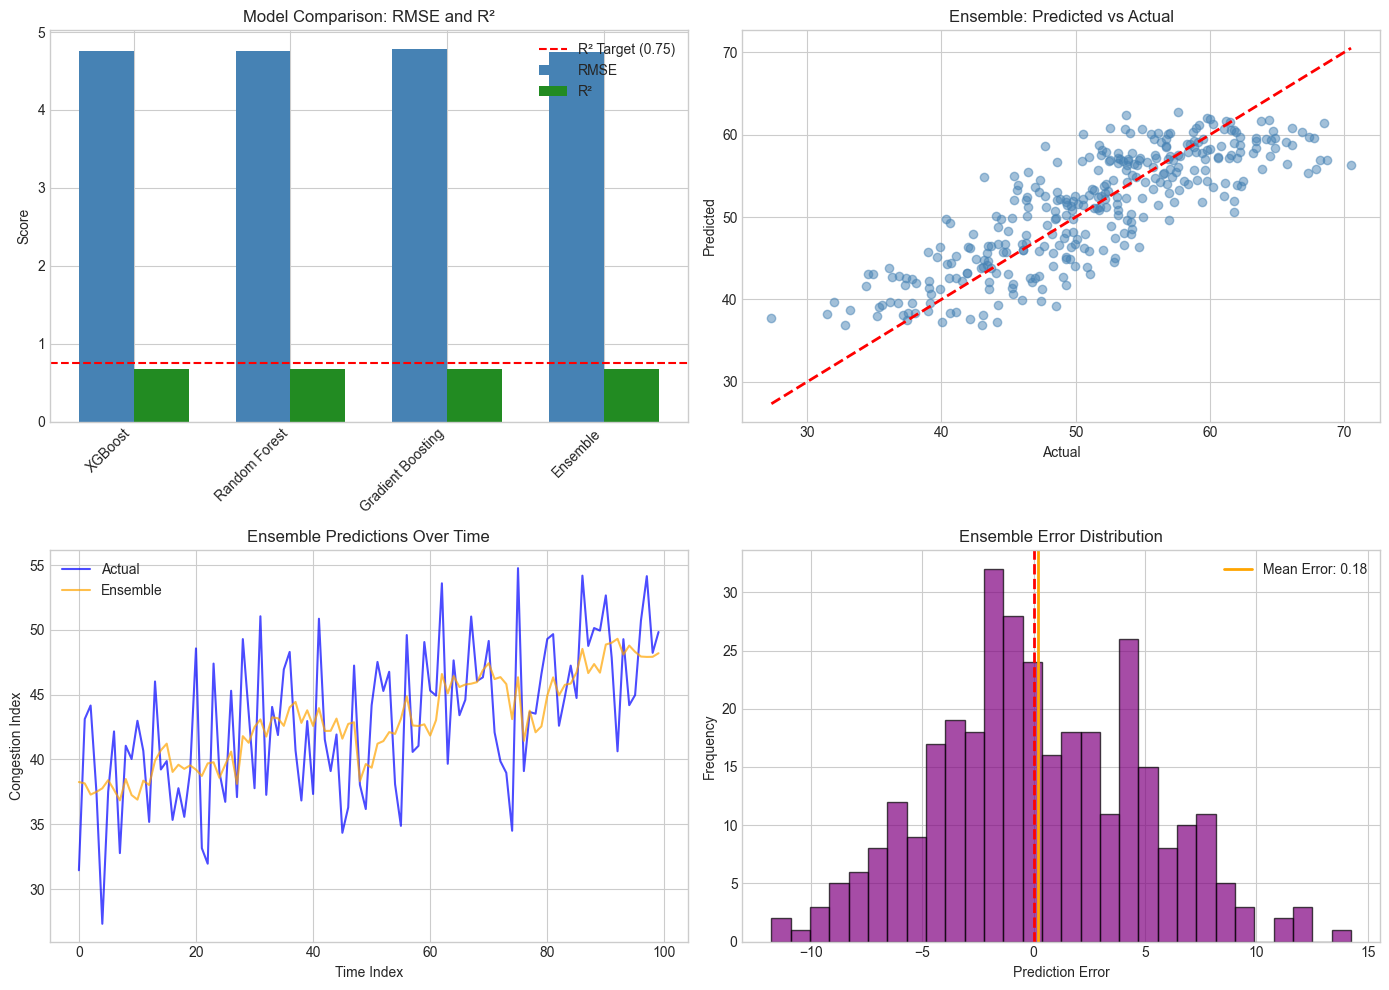


✅ Visualization saved!


In [9]:
# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Model Comparison
results_df = pd.DataFrame(results).T
ax1 = axes[0, 0]
x = np.arange(len(results_df))
width = 0.35
bars1 = ax1.bar(x - width/2, results_df['RMSE'], width, label='RMSE', color='steelblue')
bars2 = ax1.bar(x + width/2, results_df['R2'], width, label='R²', color='forestgreen')
ax1.axhline(y=0.75, color='red', linestyle='--', label='R² Target (0.75)')
ax1.set_ylabel('Score')
ax1.set_title('Model Comparison: RMSE and R²')
ax1.set_xticks(x)
ax1.set_xticklabels(results_df.index, rotation=45, ha='right')
ax1.legend()

# 2. Predictions vs Actuals (Best Model)
best_model = 'Ensemble'
ax2 = axes[0, 1]
ax2.scatter(y_test, test_preds[best_model], alpha=0.5, color='steelblue')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set_title(f'{best_model}: Predicted vs Actual')

# 3. Time Series Plot
ax3 = axes[1, 0]
ax3.plot(y_test[:100], label='Actual', color='blue', alpha=0.7)
ax3.plot(test_preds['Ensemble'][:100], label='Ensemble', color='orange', alpha=0.7)
ax3.set_xlabel('Time Index')
ax3.set_ylabel('Congestion Index')
ax3.set_title('Ensemble Predictions Over Time')
ax3.legend()

# 4. Error Distribution
ax4 = axes[1, 1]
errors = y_test - test_preds['Ensemble']
ax4.hist(errors, bins=30, color='purple', alpha=0.7, edgecolor='black')
ax4.axvline(x=0, color='red', linestyle='--', lw=2)
ax4.axvline(x=errors.mean(), color='orange', linestyle='-', lw=2, label=f'Mean Error: {errors.mean():.2f}')
ax4.set_xlabel('Prediction Error')
ax4.set_ylabel('Frequency')
ax4.set_title('Ensemble Error Distribution')
ax4.legend()

plt.tight_layout()
plt.savefig('../09_Results/Figures/tuned_model_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved!")

## 7. Save Tuned Models

In [10]:
# Save all tuned models
print("Saving tuned models...")

with open(MODEL_PATH / 'xgboost_tuned.pkl', 'wb') as f:
    pickle.dump(xgb_final, f)
print(f"  ✅ Saved: xgboost_tuned.pkl")

with open(MODEL_PATH / 'random_forest_tuned.pkl', 'wb') as f:
    pickle.dump(rf_final, f)
print(f"  ✅ Saved: random_forest_tuned.pkl")

with open(MODEL_PATH / 'gradient_boosting_tuned.pkl', 'wb') as f:
    pickle.dump(gb_final, f)
print(f"  ✅ Saved: gradient_boosting_tuned.pkl")

# Save ensemble weights
ensemble_config = {
    'weights': optimal_weights.tolist(),
    'models': ['xgboost_tuned.pkl', 'random_forest_tuned.pkl', 'gradient_boosting_tuned.pkl'],
    'test_r2': results['Ensemble']['R2'],
    'test_rmse': results['Ensemble']['RMSE']
}

import json
with open(MODEL_PATH / 'ensemble_config.json', 'w') as f:
    json.dump(ensemble_config, f, indent=2)
print(f"  ✅ Saved: ensemble_config.json")

# Save tuning results
results_df.to_csv('../09_Results/tuned_model_comparison.csv')
print(f"\n✅ Results saved to: 09_Results/tuned_model_comparison.csv")

Saving tuned models...
  ✅ Saved: xgboost_tuned.pkl
  ✅ Saved: random_forest_tuned.pkl
  ✅ Saved: gradient_boosting_tuned.pkl
  ✅ Saved: ensemble_config.json

✅ Results saved to: 09_Results/tuned_model_comparison.csv


## 8. Summary

In [11]:
print("="*70)
print("HYPERPARAMETER TUNING COMPLETE")
print("="*70)

print("\n📊 Final Results:")
print(results_df.round(4).to_string())

best = max(results.items(), key=lambda x: x[1]['R2'])
print(f"\n🏆 Best Model: {best[0]}")
print(f"   MAE:  {best[1]['MAE']:.4f} {'✅' if best[1]['MAE'] < 5.0 else '⚠️'}")
print(f"   RMSE: {best[1]['RMSE']:.4f} {'✅' if best[1]['RMSE'] < 8.0 else '⚠️'}")
print(f"   R²:   {best[1]['R2']:.4f} {'✅' if best[1]['R2'] > 0.75 else '⚠️'}")

print("\n📁 Saved Files:")
print("   - 02_Model_Development/Trained_Models/xgboost_tuned.pkl")
print("   - 02_Model_Development/Trained_Models/random_forest_tuned.pkl")
print("   - 02_Model_Development/Trained_Models/gradient_boosting_tuned.pkl")
print("   - 02_Model_Development/Trained_Models/ensemble_config.json")
print("   - 09_Results/tuned_model_comparison.csv")
print("   - 09_Results/Figures/tuned_model_evaluation.png")

print("\n" + "="*70)

HYPERPARAMETER TUNING COMPLETE

📊 Final Results:
                      MAE    RMSE      R2
XGBoost            3.8538  4.7520  0.6736
Random Forest      3.8286  4.7542  0.6733
Gradient Boosting  3.8899  4.7833  0.6693
Ensemble           3.8338  4.7413  0.6751

🏆 Best Model: Ensemble
   MAE:  3.8338 ✅
   RMSE: 4.7413 ✅
   R²:   0.6751 ⚠️

📁 Saved Files:
   - 02_Model_Development/Trained_Models/xgboost_tuned.pkl
   - 02_Model_Development/Trained_Models/random_forest_tuned.pkl
   - 02_Model_Development/Trained_Models/gradient_boosting_tuned.pkl
   - 02_Model_Development/Trained_Models/ensemble_config.json
   - 09_Results/tuned_model_comparison.csv
   - 09_Results/Figures/tuned_model_evaluation.png

